In [2]:
# Install the required libraries
!pip install prophet

In [3]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet
from matplotlib import pyplot as plt
import gdown
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#URLs for downloading the updated forecast files
url_bitcoin = 'https://drive.google.com/uc?id=1g_bLlJpB0B9TkPEnTwCmeGlhZVqTOZ5L'
gdown.download(url_bitcoin, 'Bitcoin_Data.csv', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1g_bLlJpB0B9TkPEnTwCmeGlhZVqTOZ5L
To: /content/Bitcoin_Data.csv
100%|██████████| 161k/161k [00:00<00:00, 51.2MB/s]


'Bitcoin_Data.csv'

In [6]:
#URLs for downloading the sp500 -Use the data file with 2014 - 2024
url_sp500 = 'https://drive.google.com/uc?id=1kL74LliyVXjr8UiwH7Wa6Td6Z4HLhY9i'
gdown.download(url_sp500, 'SP500_Data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kL74LliyVXjr8UiwH7Wa6Td6Z4HLhY9i
To: /content/SP500_Data.csv
100%|██████████| 111k/111k [00:00<00:00, 17.4MB/s]


'SP500_Data.csv'

In [7]:
#Read the URL_Bitcoin into a dataframe
bitcoin_df = pd.read_csv(url_bitcoin,
                 index_col="Date",
                 parse_dates=True
                )

# Drop any values that are blank
bitcoin_df = bitcoin_df.dropna()

# Drop Column '% Change'
bitcoin_df = bitcoin_df.drop(columns="Change %")

# Preview the dataset
bitcoin_df.head()

,Price,Open,High,Low,Vol.
Date,,,,,
2024-12-09,"97,359.4","101,129.7","101,198.6","94,395.8",321.01K
2024-12-08,"101,115.8","99,837.0","101,339.9","98,713.9",128.93K
2024-12-07,"99,837.0","99,757.2","100,441.8","98,969.0",118.44K
2024-12-06,"99,760.7","96,968.9","101,908.5","96,452.0",213.49K
2024-12-05,"96,970.8","98,624.8","103,719.4","92,510.4",245.79K


In [9]:
#Read the URL_SP500 into a dataframe
sp500_df = pd.read_csv(url_sp500,
                 index_col="Date",
                 parse_dates=True
                )

# Drop any values that are blank
sp500_df = sp500_df.dropna()

# Preview the dataset
sp500_df.head()
sp500_df.tail()

,Close/Last,Open,High,Low
Date,,,,
2014-12-19,2070.65,2061.04,2077.85,2061.03
2014-12-18,2061.23,2018.98,2061.23,2018.98
2014-12-17,2012.89,1973.77,2016.75,1973.77
2014-12-16,1972.74,1986.71,2016.89,1972.56
2014-12-15,1989.63,2005.03,2018.69,1982.26


In [10]:
# Clean the columns of the data
bitcoin_df.columns = ["Price", "Open", "High", "Low", "Volume"]
bitcoin_df.head()

,Price,Open,High,Low,Volume
Date,,,,,
2024-12-09,"97,359.4","101,129.7","101,198.6","94,395.8",321.01K
2024-12-08,"101,115.8","99,837.0","101,339.9","98,713.9",128.93K
2024-12-07,"99,837.0","99,757.2","100,441.8","98,969.0",118.44K
2024-12-06,"99,760.7","96,968.9","101,908.5","96,452.0",213.49K
2024-12-05,"96,970.8","98,624.8","103,719.4","92,510.4",245.79K


In [11]:
# Clean the columns of the SP500data
sp500_df.columns = ["Price", "Open", "High", "Low"]
sp500_df.head(5)

,Price,Open,High,Low
Date,,,,
2024-12-13,6051.09,6068.17,6078.58,6035.77
2024-12-12,6051.25,6074.29,6079.68,6051.25
2024-12-11,6084.19,6060.15,6092.59,6060.15
2024-12-10,6034.91,6057.59,6065.40,6029.89
2024-12-09,6052.85,6083.01,6088.51,6048.63


In [12]:
# Convert the Price column to numeric and ignore the comma
bitcoin_df['Price'] = bitcoin_df['Price'].str.replace(',', '').astype(float)
bitcoin_df['Open'] = bitcoin_df['Open'].str.replace(',', '').astype(float)
bitcoin_df['High'] = bitcoin_df['High'].str.replace(',', '').astype(float)
bitcoin_df['Low'] = bitcoin_df['Low'].str.replace(',', '').astype(float)

In [13]:

# Create a function to convert K, M and B
def convert_k_to_number(value):
  if isinstance(value, str) and 'K' in value:
    return float(value.replace('K', '')) * 1000
    return float(value)

  if isinstance(value, str) and 'M' in value:
    return float(value.replace('M', '')) * 1000000
    return float(value)

  if isinstance(value, str) and 'B' in value:
    return float(value.replace('B', '')) * 1000000000
    return float(value)

# Apply the function to the Volume Column
bitcoin_df['Volume'] = bitcoin_df['Volume'].apply(convert_k_to_number)

In [14]:
#Convert the SP500 Price column to numeric
sp500_df['Price'] = sp500_df['Price'].astype(float)
sp500_df['Open'] = sp500_df['Open'].astype(float)
sp500_df['High'] = sp500_df['High'].astype(float)
sp500_df['Low'] = sp500_df['Low'].astype(float)
sp500_df.dtypes


,0
Price,float64
Open,float64
High,float64
Low,float64


In [15]:
# Sort the dataframe by Volume values
bitcoin_df = bitcoin_df.sort_values(by='Volume', ascending=True)
bitcoin_df.head(8)


,Price,Open,High,Low,Volume
Date,,,,,
2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0
2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0
2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0
2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0
2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0
2023-08-26,26017.1,26057.2,26114.1,25993.5,12090.0
2023-09-23,26579.2,26581.7,26636.2,26517.5,12920.0
2023-09-09,25901.1,25909.5,25938.5,25814.3,13480.0


In [16]:
# Sort the SP500 dataframe by Volume values
sp500_df = sp500_df.sort_values(by='Price', ascending=True)
sp500_df.head(8)

,Price,Open,High,Low
Date,,,,
2016-02-11,1829.08,1847.00,1847.00,1810.10
2016-02-10,1851.86,1857.10,1881.60,1850.32
2016-02-09,1852.21,1848.46,1868.25,1834.94
2016-02-08,1853.44,1873.25,1873.25,1828.46
2016-01-20,1859.33,1876.18,1876.18,1812.29
2016-02-12,1864.78,1833.40,1864.78,1833.40
2015-08-25,1867.61,1898.08,1948.04,1867.08
2016-01-21,1868.99,1861.46,1889.85,1848.98


In [17]:
# Reset the index so that we recode the columns for Prophet
bitcoin_df.reset_index(inplace=True)

In [18]:
# Reset the index so that we recode the columns for Prophet
sp500_df.reset_index(inplace=True)
sp500_df.head(5)


,Date,Price,Open,High,Low
0,2016-02-11,1829.08,1847.00,1847.00,1810.10
1,2016-02-10,1851.86,1857.10,1881.60,1850.32
2,2016-02-09,1852.21,1848.46,1868.25,1834.94
3,2016-02-08,1853.44,1873.25,1873.25,1828.46
4,2016-01-20,1859.33,1876.18,1876.18,1812.29


In [19]:
# Create a DataFrame for Bitcoin to include the Date and Price columns only
prophet_bitcoin_df = bitcoin_df[["Date", "Price"]]

# Rename the columns to the Prophet model syntax
prophet_bitcoin_df.columns = ["ds", "y"]

# Preview the dataset
prophet_bitcoin_df.head()


,ds,y
0,2021-08-03,38130.3
1,2020-12-25,24689.6
2,2021-08-16,45996.3
3,2021-03-04,48428.0
4,2023-08-12,29428.2


In [20]:
# Create a DataFrame for Bitcoin to include the Date and Price columns only
prophet_sp500_df = sp500_df[["Date", "Price"]]

# Rename the columns to the Prophet model syntax
prophet_sp500_df.columns = ["ds", "y"]

# Preview the dataset
prophet_sp500_df.head()

,ds,y
0,2016-02-11,1829.08
1,2016-02-10,1851.86
2,2016-02-09,1852.21
3,2016-02-08,1853.44
4,2016-01-20,1859.33


In [21]:
# Call the Prophet function, store as an object
m = Prophet()


In [22]:
m1 = Prophet()

In [23]:
# Fit the time-series model.
m.fit(prophet_bitcoin_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeej3lbr8/rndvoyca.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeej3lbr8/aqgzf3vz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21604', 'data', 'file=/tmp/tmpeej3lbr8/rndvoyca.json', 'init=/tmp/tmpeej3lbr8/aqgzf3vz.json', 'output', 'file=/tmp/tmpeej3lbr8/prophet_modeld1tubjn3/prophet_model-20241215225918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
m1.fit(prophet_sp500_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeej3lbr8/yqqx2soh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeej3lbr8/xq6b51ed.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6239', 'data', 'file=/tmp/tmpeej3lbr8/yqqx2soh.json', 'init=/tmp/tmpeej3lbr8/xq6b51ed.json', 'output', 'file=/tmp/tmpeej3lbr8/prophet_modelusgrwdsv/prophet_model-20241215225921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as approx 385 days
future_bitcoin_trends = m.make_future_dataframe(periods=385, freq='D')

# View the last five rows of the future_bitcoin_trends DataFrame
display(future_bitcoin_trends.tail(5))

,ds
2550,2025-12-25
2551,2025-12-26
2552,2025-12-27
2553,2025-12-28
2554,2025-12-29


In [26]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as approx 385 days
future_sp500_trends = m1.make_future_dataframe(periods=390, freq='D')

# View the last five rows of the future_bitcoin_trends DataFrame
display(future_sp500_trends.tail(5))

,ds
2912,2026-01-03
2913,2026-01-04
2914,2026-01-05
2915,2026-01-06
2916,2026-01-07


In [27]:
# Make the predictions for the trend data using the future_bitcoin_trends DataFrame
forecast_bitcoin_trends = m.predict(future_bitcoin_trends)

# Display the first five rows of the forecast_bitcoin_trends DataFrame
display(forecast_bitcoin_trends.tail(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2550,2025-12-25,124717.291374,97732.813670,151125.391474,99694.916335,151727.200949,-1218.518178,-1218.518178,-1218.518178,-36.706218,-36.706218,-36.706218,-1181.811960,-1181.811960,-1181.811960,0.0,0.0,0.0,123498.773195
2551,2025-12-26,124827.798126,98585.253583,151972.408560,99747.697430,151901.518378,-977.928919,-977.928919,-977.928919,-8.705240,-8.705240,-8.705240,-969.223679,-969.223679,-969.223679,0.0,0.0,0.0,123849.869207
2552,2025-12-27,124938.304878,98245.949820,151921.060924,99765.307424,152075.835807,-771.436827,-771.436827,-771.436827,-29.511097,-29.511097,-29.511097,-741.925730,-741.925730,-741.925730,0.0,0.0,0.0,124166.868051
2553,2025-12-28,125048.811630,98376.744750,151935.146809,99753.906524,152250.153236,-518.911826,-518.911826,-518.911826,-14.161288,-14.161288,-14.161288,-504.750537,-504.750537,-504.750537,0.0,0.0,0.0,124529.899805
2554,2025-12-29,125159.318383,99664.413041,152682.485963,99742.505624,152424.470664,-195.210379,-195.210379,-195.210379,67.499861,67.499861,67.499861,-262.710240,-262.710240,-262.710240,0.0,0.0,0.0,124964.108004


In [28]:
# Make the predictions for the trend data using the future_bitcoin_trends DataFrame
forecast_sp500_trends = m1.predict(future_sp500_trends)

# Display the first five rows of the forecast_bitcoin_trends DataFrame
display(forecast_sp500_trends.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-12-15,2061.666020,1939.743598,2243.020777,2061.666020,2061.666020,33.318543,33.318543,33.318543,16.327175,16.327175,16.327175,16.991369,16.991369,16.991369,0.0,0.0,0.0,2094.984563
1,2014-12-16,2061.572320,1948.693123,2231.665930,2061.572320,2061.572320,32.331523,32.331523,32.331523,17.307800,17.307800,17.307800,15.023722,15.023722,15.023722,0.0,0.0,0.0,2093.903843
2,2014-12-17,2061.478621,1940.357375,2253.998718,2061.478621,2061.478621,29.900558,29.900558,29.900558,16.674760,16.674760,16.674760,13.225798,13.225798,13.225798,0.0,0.0,0.0,2091.379179
3,2014-12-18,2061.384922,1942.570053,2230.472468,2061.384922,2061.384922,28.370110,28.370110,28.370110,16.755386,16.755386,16.755386,11.614724,11.614724,11.614724,0.0,0.0,0.0,2089.755032
4,2014-12-19,2061.291222,1951.921996,2232.185793,2061.291222,2061.291222,27.778229,27.778229,27.778229,17.574993,17.574993,17.574993,10.203236,10.203236,10.203236,0.0,0.0,0.0,2089.069451


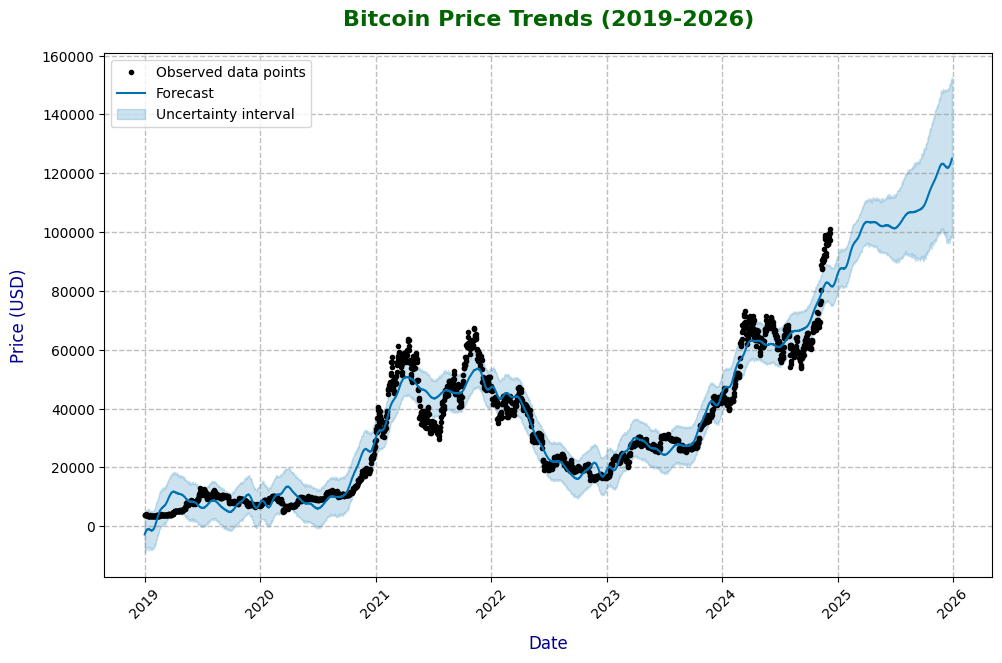

In [29]:
# From the forecast_bitcoin_trends DataFrame, plot the data to visualize
m.plot(forecast_bitcoin_trends);

plt.xlabel("Date", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.ylabel("Price (USD)", fontsize=12, labelpad=10, color='darkblue')  # Label font and spacing
plt.title("Bitcoin Price Trends (2019-2026)", fontsize=16, fontweight='bold', color='darkgreen', pad=20)  # Bold and larger title
# Formatting x-axis for better readability
plt.xticks(rotation=45, fontsize=10)  # Rotate x-ticks
# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid with light styling
plt.legend(loc='upper left', fontsize=10)  # Add legend
plt.show()

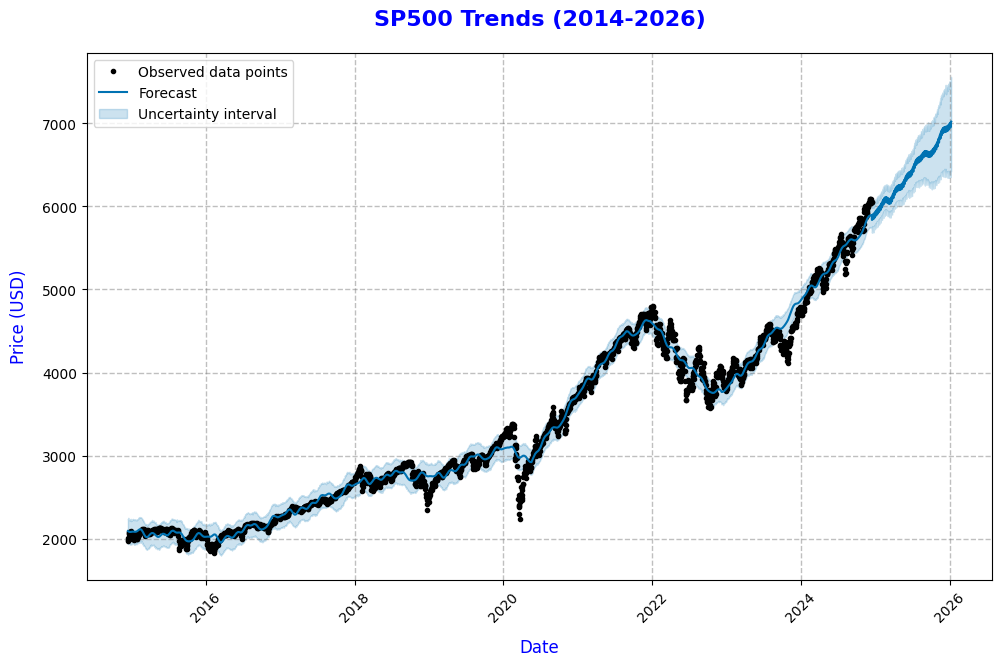

In [32]:
m1.plot(forecast_sp500_trends);
plt.xlabel("Date", fontsize=12, labelpad=10, color='blue')  # Label font and spacing
plt.ylabel("Price (USD)", fontsize=12, labelpad=10, color='blue')  # Label font and spacing
plt.title("SP500 Trends (2014-2026)", fontsize=16, fontweight='bold', color='Blue', pad=20)  # Bold and larger title
# Formatting x-axis for better readability
plt.xticks(rotation=45, fontsize=10)  # Rotate x-ticks
# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)  # Add grid with light styling
plt.legend(loc='upper left', fontsize=10)  # Add legend
plt.show()



In [33]:
# Save the forecast dataframe to a csv
forecast_bitcoin_trends.to_csv("forecast_bitcoin_trends.csv")

In [34]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
bitcoin_df['Stock Volatility'] = bitcoin_df['Price'].rolling(window=4).std()
bitcoin_df.head()

,Date,Price,Open,High,Low,Volume,Stock Volatility
0,2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0,NaN
1,2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0,NaN
2,2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0,NaN
3,2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,10692.556843
4,2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0,11836.908845


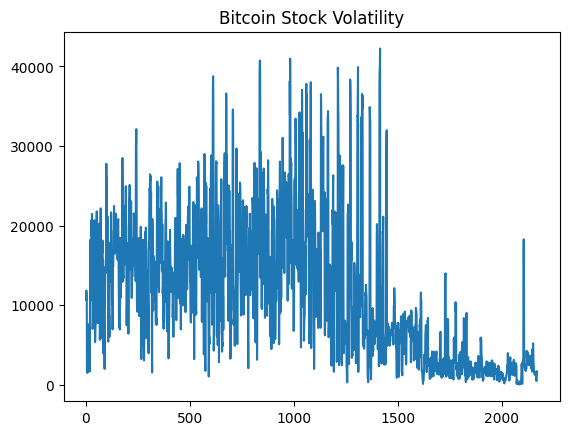

In [35]:
# Visualize the stock volatility
bitcoin_df['Stock Volatility'].plot(title="Bitcoin Stock Volatility");


In [36]:
# Create a new column in the DataFrame called Stock Volatility for SP500
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
sp500_df['Stock Volatility'] = sp500_df['Price'].rolling(window=4).std()
sp500_df.head()

,Date,Price,Open,High,Low,Stock Volatility
0,2016-02-11,1829.08,1847.00,1847.00,1810.10,NaN
1,2016-02-10,1851.86,1857.10,1881.60,1850.32,NaN
2,2016-02-09,1852.21,1848.46,1868.25,1834.94,NaN
3,2016-02-08,1853.44,1873.25,1873.25,1828.46,11.731250
4,2016-01-20,1859.33,1876.18,1876.18,1812.29,3.479933


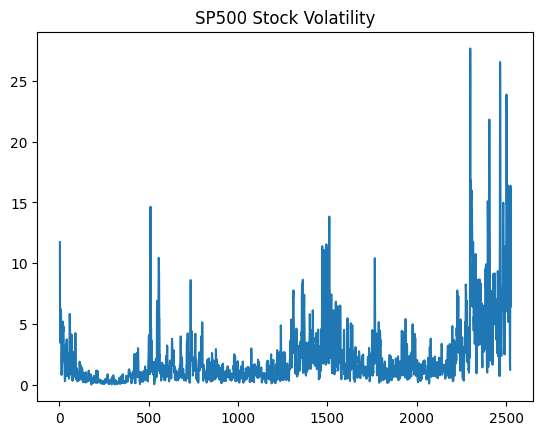

In [37]:
# Visualize the stock volatility for SP500
sp500_df['Stock Volatility'].plot(title="SP500 Stock Volatility");

In [ ]:
# Export new dataframe for bitcoin_analysis_dataframe
bitcoin_df.to_csv("bitcoin_analysis_dataframe.csv")
bitcoin_df.head()

,Date,Price,Open,High,Low,Volume,Stock Volatility
0,2021-08-03,38130.3,39167.4,39766.6,37688.2,260.0,NaN
1,2020-12-25,24689.6,23728.7,24778.9,23445.3,2400.0,NaN
2,2021-08-16,45996.3,46991.6,48002.4,45672.1,2410.0,NaN
3,2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,10692.556843
4,2023-08-12,29428.2,29420.8,29480.8,29375.4,11070.0,11836.908845
